In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

IMPORTAMOS LOS PESOS Y LA CONFIGURACION DE NUESTRA RED

In [30]:
section_detect = cv2.dnn.readNet('redes_entrenadas\custom-yolov4-detector.cfg','redes_entrenadas\custom-yolov4-detector_last.weights')

In [31]:
#traemos las clases
classes =[]
with open("redes_entrenadas\coco.names",'r') as f:
  classes=f.read().splitlines()

In [32]:
classes[0:3]

['fecha', 'firma1', 'firma2']

In [33]:
len(classes)

3

Cargamos imagen

In [34]:
#cargar imagen
img=cv2.imread('prueba\C_48.jpg')

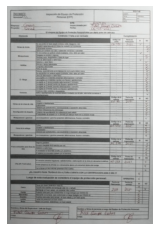

In [35]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [36]:
img.shape

(814, 543, 3)

In [37]:
height, width = img.shape[:2]

In [38]:
#Realizamos el acondicionamiento de la imagen para que entre a la red
blob = cv2.dnn.blobFromImage(img, scalefactor = 1/255, size = (416, 416), mean= (0, 0, 0), swapRB = True, crop=False)

In [39]:
section_detect.setInput(blob)

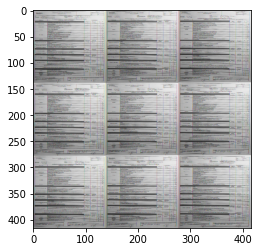

In [40]:
i=blob[0].reshape(416,416,3)
plt.imshow(i)

In [41]:
output_layer_names=section_detect.getUnconnectedOutLayersNames() #obtiene la lista de las capas finales
layerout=section_detect.forward(output_layer_names)#obtiene el valor de salida de las capas indicadas.

In [42]:
#lo sgte nos permite ver las capas de salida de la red yolo V4
output_layer_names

['yolo_139', 'yolo_150', 'yolo_161']

La salida nos proporciona muchas cajas y cada caja tiene sus respectivos scores para las 3 clases.Luego tenemos que escoger el mayor de estos scores para compararlo con nuestro confidence.
Si es mayor que confidence significa que es un objeto detectado

Algo para resaltar es que layerout tendra diferentes cantidad de cajas por 'yolo_139','yolo_159' y 'yolo_161,asi que hay que entrar dentro de esos arrays para encontrar nuestras cajas con objetos detectados

In [43]:
boxes =[]
confidences=[]
class_ids=[]
for output in layerout:#entra en layerout
  for detection in output:
    score=detection[5:]
    class_id=np.argmax(score)#Identifica el score mas alto de la clase del objeto detectado mediante la máxima confianza
    confidence=score[class_id]
    if confidence>0.94:
      # El objeto es detectado
      center_x = int(detection[0] * width) #convertimos el centro x
      center_y = int(detection[1] * height)#convertimos el centro y
      w = int(detection[2] * width)#el ancho se multiplica por el valor de la imagen original
      h = int(detection[3] * height)#el alto se multiplica por el valor de la imagen original

      x=int(center_x -w/2)
      y=int(center_y -h/2)
      boxes.append([x,y,w,h])
      confidences.append(float(confidence))
      class_ids.append(class_id)
      print(boxes)

[[231, 75, 190, 15]]
[[231, 75, 190, 15], [6, 740, 227, 60]]
[[231, 75, 190, 15], [6, 740, 227, 60], [8, 747, 222, 48]]
[[231, 75, 190, 15], [6, 740, 227, 60], [8, 747, 222, 48], [256, 746, 274, 51]]
[[231, 75, 190, 15], [6, 740, 227, 60], [8, 747, 222, 48], [256, 746, 274, 51], [259, 746, 276, 51]]
[[231, 75, 190, 15], [6, 740, 227, 60], [8, 747, 222, 48], [256, 746, 274, 51], [259, 746, 276, 51], [10, 739, 220, 64]]
[[231, 75, 190, 15], [6, 740, 227, 60], [8, 747, 222, 48], [256, 746, 274, 51], [259, 746, 276, 51], [10, 739, 220, 64], [251, 738, 279, 58]]


In [44]:
#asegura que no se repitan las cajas

indices=cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=0.5, nms_threshold=0.4)

In [45]:
class_ids

[0, 1, 1, 2, 2, 1, 2]

In [46]:
index_sel=indices.flatten().tolist()

In [47]:
index_sel

[1, 6, 0]

In [48]:
len(boxes)


7

Dibujo de los cuadros en la imagen

In [49]:
colors = np.random.uniform(0, 255, size=(len(classes),3))

In [50]:
#funcion que acepta la imagen ,los boxes de la imagen,la clase y el color
def draw_bouding_boxes(img,boxes,confidences,nms_indexes,class_ids,colors):
    for count, i in enumerate(nms_indexes):
        x, y, w, h = boxes[i]
        print(boxes[i])
        label = str(classes[class_ids[i]]) + ' :' + str(int(confidences[i]*100)) + '%'
        color = colors[count]
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 1)
        cv2.putText(img, label, (x, y - 15),cv2.FONT_HERSHEY_PLAIN ,2, color, 2)
    return img

[6, 740, 227, 60]
[251, 738, 279, 58]
[231, 75, 190, 15]


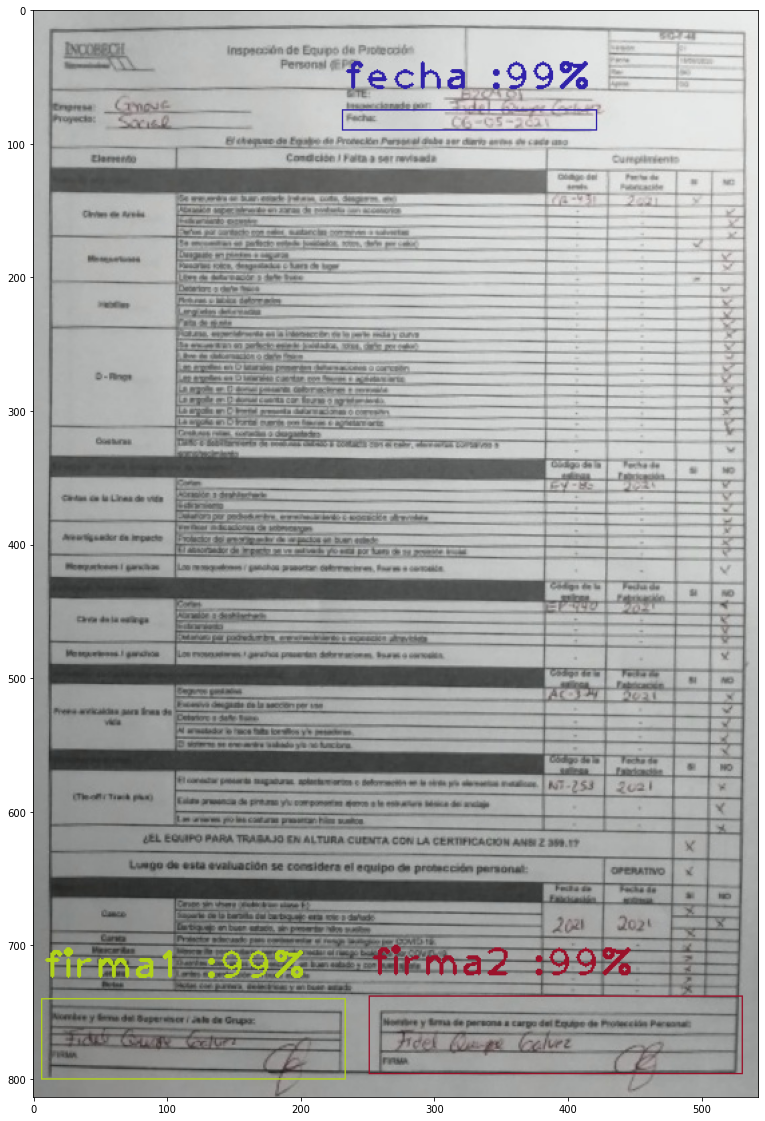

In [51]:
#ver imagen detectada
draw_bouding_boxes(img,boxes,confidences,index_sel,class_ids,colors)
plt.figure(figsize=(30,20))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
